In [1]:
import os, glob
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import RFormula

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(font_scale=1.5, rc={'text.usetex' : True})

sc = SparkContext('local')
spark = SparkSession(sc)

path = "./input/clean/training_data/"

In [2]:
NC_data = spark.read.csv(path + "NOAA_NC_DAvg_training_data.csv", header=True, inferSchema=True)
NC_data = NC_data.drop(*[t for t in NC_data.columns if t[-1] == 'T']+['date','CLASS'])
NC_data.show(5)

+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+------------------+
|             ATemp|           MaxTemp|           MinTemp|               RH|            MaxRH|            MinRH|                BP|             MaxBP|             MinBP|              WSpd|              Wdir|            SDWDir|           MaxWSpd|            MinWSpd|             TotPrcp|            TotPAR|           AvgVolt|              Temp|
+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------

In [3]:
# vector of features
rf = RFormula(formula="Temp~.")
vector_rf = rf.fit(NC_data).transform(NC_data).select(["features","label"])
vector_rf.show(5)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[8.29687499999999...|10.641145833333328|
|[11.0645833333333...|11.089062499999999|
|[15.5343749999999...|12.167708333333321|
|[19.1302083333333...|13.960937499999993|
|[19.6677083333333...|15.548437499999999|
+--------------------+------------------+
only showing top 5 rows



In [4]:
# normalizing data for improved learning algorithms
from pyspark.mllib.util import MLUtils 
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaled_model = scaler.fit(vector_rf)
NC_scaled = scaled_model.transform(vector_rf)
NC_scaled.show(10)

+--------------------+------------------+--------------------+
|            features|             label|      scaledFeatures|
+--------------------+------------------+--------------------+
|[8.29687499999999...|10.641145833333328|[1.05959159298474...|
|[11.0645833333333...|11.089062499999999|[1.41305485256546...|
|[15.5343749999999...|12.167708333333321|[1.98389070008556...|
|[19.1302083333333...|13.960937499999993|[2.44311357252540...|
|[19.6677083333333...|15.548437499999999|[2.51175754766415...|
|[9.70416666666666...|13.901562500000011|[1.23931641936545...|
|[1.26770833333333...| 9.498437499999998|[0.16189867779817...|
|[2.97708333333333...|  8.69322916666667|[0.38020248245453...|
|[2.93437499999999...| 8.937500000000002|[0.37474821311211...|
|[-0.6145833333333...| 6.936458333333337|[-0.0784882661470...|
+--------------------+------------------+--------------------+
only showing top 10 rows



In [5]:
# splitting data into train and test set
train,test = NC_scaled.randomSplit([0.80,0.20],42069)

In [6]:
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression

glr = GeneralizedLinearRegression(family="gaussian", link="identity", featuresCol="scaledFeatures", maxIter=10, regParam=0.3)
gl_model = glr.fit(train)
print("Coefficients: "+ str(gl_model.coefficients))
print("Intercept: "+ str(gl_model.intercept))

Coefficients: [2.3172461229558645,2.2528419614083925,2.385091799974504,-0.03417534872192436,0.49424116151261077,-0.501761113157687,0.15961115107433546,0.008353893296827465,0.24912926948887834,1.0150396791218184,0.31912254373916465,0.6238241508857439,-0.825705622218722,-0.31622919987604137,0.2627996998679184,0.42398423748813063,-0.3911640078585115]
Intercept: -37.60975474403549


In [7]:
from pyspark.ml.evaluation import RegressionEvaluator
gl_pred = gl_model.transform(test)
gl_eval = RegressionEvaluator(predictionCol = "prediction", labelCol="label", metricName = "rmse")
gl_eval.evaluate(gl_pred)

2.061670244376662

In [8]:
# lasso regression
lasso = LinearRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=.2, elasticNetParam=1)
lasso_model = lasso.fit(train)
sns.set(font_scale=1.5, rc={'text.usetex' : True})
print("Coefficients: "+ str(lasso_model.coefficients))
print("Intercept: "+ str(lasso_model.intercept))

Coefficients: [2.3078156696181065,2.301896831440173,2.314285041734375,0.0,0.0,0.0,0.08824384798475148,0.01030631029270439,0.09034128917850191,0.0,0.059050604277547304,0.34167487223519155,-0.04639857174743558,0.0,0.0,0.0,-0.04152583774501742]
Intercept: -24.584058581248303


In [9]:
lasso_pred = lasso_model.transform(test)
lasso_eval = RegressionEvaluator(predictionCol = "prediction", labelCol="label", metricName = "rmse")
lasso_eval.evaluate(lasso_pred)

2.150451915194875

In [10]:
# tuning for the best regularization parameter
lr_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
lasso_rmse = []
for i in np.arange(0,2,0.1):
    lr = LinearRegression(featuresCol="scaledFeatures",labelCol="label", maxIter=10, regParam=i, elasticNetParam=1.0)
    lr_model = lr.fit(train)
    lr_pred = lr_model.transform(test)
    lasso_rmse.append(lr_eval.evaluate(lr_pred))

Coefficients: [2.3432107687055166,2.335496980080808,2.351507018736541,0.0,0.0,0.0,0.11665823538224018,0.11677310259646878,0.11570376864035758,0.0,0.2021151609606195,0.4561639633057909,-0.06630448131389101,0.0,0.08316706491276028,0.21425489512402357,-0.22106490695694275]
Intercept: -38.05068552325747


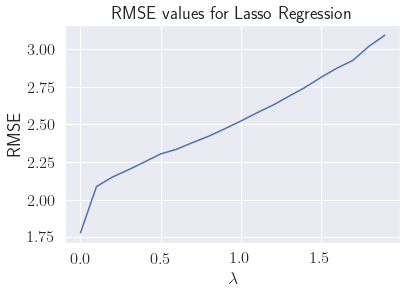

In [11]:
sns.lineplot(np.arange(0,2,0.1), lasso_rmse)
plt.title("RMSE values for Lasso Regression")
plt.xlabel(r"$\lambda$")
plt.ylabel("RMSE")
lasso = LinearRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=.1, elasticNetParam=1)
lasso_model = lasso.fit(train)

print("Coefficients: "+ str(lasso_model.coefficients))
print("Intercept: "+ str(lasso_model.intercept))

In [12]:
# ridge regression
ridge = LinearRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=.2, elasticNetParam=0)
ridge_model = ridge.fit(train)

print("Coefficients: "+ str(ridge_model.coefficients))
print("Intercept: "+ str(ridge_model.intercept))

Coefficients: [2.339352956389189,2.243090524957954,2.4408348252052297,-0.05864324026049526,0.7135641687720012,-0.7401801850293638,0.16411801906848109,-0.03911532411969831,0.29192111334396587,1.4695510536875782,0.32682521485079896,0.6813504986932989,-1.1169257400094588,-0.48067575320325046,0.26203237378562805,0.37865033705974643,-0.38018443928166334]
Intercept: -38.67617799274696


In [13]:
ridge_pred = ridge_model.transform(test)
ridge_eval = RegressionEvaluator(predictionCol = "prediction", labelCol="label", metricName = "rmse")
ridge_eval.evaluate(ridge_pred)

2.042316488371575

In [14]:
# tuning for the best regularization parameter
ridge_rmse = []
for i in np.arange(0,2,0.1):
    lr = LinearRegression(featuresCol="scaledFeatures",labelCol="label", maxIter=10, regParam=i, elasticNetParam=0.0)
    lr_model = lr.fit(train)
    lr_pred = lr_model.transform(test)
    ridge_rmse.append(lr_eval.evaluate(lr_pred))

Coefficients: [2.3637887521038556,2.1749203186080996,2.563265743477775,-0.10829495936017312,1.3019265405393923,-1.3490194010919603,0.15368932681982483,-0.1485599149014684,0.38569477514024314,2.5769381483138245,0.34222367296543216,0.7896368832307255,-1.8210275426329525,-0.901472124381682,0.25661968827523607,0.30214098405697226,-0.36037796670015904]
Intercept: -36.62269640847665


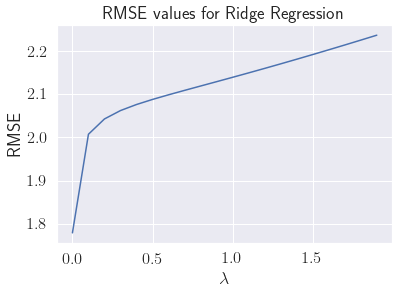

In [15]:
sns.lineplot(np.arange(0,2,0.1), ridge_rmse)
plt.title("RMSE values for Ridge Regression")
plt.xlabel(r"$\lambda$")
plt.ylabel("RMSE")
ridge = LinearRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=.1, elasticNetParam=0)
ridge_model = ridge.fit(train)

print("Coefficients: "+ str(ridge_model.coefficients))
print("Intercept: "+ str(ridge_model.intercept))